In this project, the Generalized Autoregressive Conditional Heteroskedasticity (GARCH) and a XGBoost Machine Learning model have been used to predict the volatility of Repsol's stock. GARCH is a widely-used statistical model for forecasting the variance of financial time series, and is particularly useful for modeling the volatility of stocks. Using historical data on Repsol's stock, we fitted a GARCH model and use it to make short-term rolling forecasts of the stock's volatility. We also compared the performance of our GARCH model to other more general Machine Learning model, XGBoost. Our results show that the XGBoost model is able to accurately predict the rolling monthly volatility of Repsol's stock and outperforms the GARCH model in out-of-sample forecasting. This project demonstrates the usefulness of Machine Learning for forecasting the volatility of stocks and highlights the importance of considering the time-varying nature of volatility in quantitative financial analysis.

About Repsol

Repsol is a Spanish energy company that engages in the exploration, development, production, and marketing of oil, natural gas, and other energy products. It is one of the largest energy companies in Spain and has operations in more than 30 countries around the world. Repsol is also involved in the development of renewable energy sources, such as wind power and solar energy.

Training period: 2002-10-28 to 2021-10-28 (5018 Trading Days)

Test period for forecasting (The model has never seen this data): 2021-10-28 to 2022-10-28 (251 Trading Days)

Predictions are done on a rolling basis, predicting monthly (22 trading days) volatility day by day

The Generalized Autoregressive Conditional Heteroscedasticity (GARCH) model is a statistical model used to describe the time-varying variance of financial time series data. It is commonly used to model the volatility of financial returns, and can be used to make predictions about future volatility.

The Extreme Gradient Boosting (XGBoost) model is a powerful machine learning algorithm used for classification and regression tasks. It is an implementation of gradient boosting that is optimized for speed and performance. XGBoost is a popular choice among data scientists because it provides a high level of accuracy while also being efficient and easy to use. It works by creating a series of decision trees and combining their predictions through an ensemble model. The algorithm can handle a variety of data types, including numerical, categorical, and missing values.

Importing Libraries

In [2]:
!pip install arch numpy pandas plotly matplotlib seaborn xgboost statsmodels ipywidgets tabulate scikit-learn
import math
import datetime
import warnings
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.figure_factory as ff
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from arch import arch_model
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from ipywidgets import HBox, VBox
from tabulate import tabulate
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
from xgboost import plot_importance, plot_tree
#Matplotlib style
plt.style.use('fivethirtyeight')
#Ignoring some warnings
warnings.filterwarnings('ignore')


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


   ---------------------------------------- 0.0/9.8 MB ? eta -:--:--
   --- ------------------------------------ 0.8/9.8 MB 4.2 MB/s eta 0:00:03
   ------- -------------------------------- 1.8/9.8 MB 4.4 MB/s eta 0:00:02
   ----------- ---------------------------- 2.9/9.8 MB 4.4 MB/s eta 0:00:02
   ----------------- ---------------------- 4.2/9.8 MB 4.5 MB/s eta 0:00:02
   --------------------- ------------------ 5.2/9.8 MB 4.6 MB/s eta 0:00:01
   ------------------------- -------------- 6.3/9.8 MB 4.6 MB/s eta 0:00:01
   ---------------------------- ----------- 7.1/9.8 MB 4.5 MB/s eta 0:00:01
   --------------------------------- ------ 8.1/9.8 MB 4.6 MB/s eta 0:00:01
   -------------------------------------- - 9.4/9.8 MB 4.8 MB/s eta 0:00:01
   ---------------------------------------  9.7/9.8 MB 4.8 MB/s eta 0:00:01
   ---------------------------------------  9.7/9.8 MB 4.8 MB/s eta 0:00:01
   ---------------------------------------  9.7/9.8 MB 4.8 MB/s eta 0:00:01
   ----------------

In [3]:
repsol_stock_raw_data = pd.read_csv(r"C:\Users\Acer\Downloads\repsol stock data\RepsolStockData20Years.csv")

#Calculate the percentage change by day
returns_repsol = 100 * repsol_stock_raw_data.close.pct_change().dropna()
#Drop 0 results, there is a error in the dataset and for 74 days,the stock market was close, so the return is 0
returns_repsol = returns_repsol.drop(returns_repsol[returns_repsol == 0].index)
#Display the 3 first rows of the Serie
returns_repsol.head(3)

1   -3.237407
2    1.486987
3    4.578755
Name: close, dtype: float64

EDA: Visualizing Returns & Volatility

In [4]:
#Average of return column
returns_repsol.mean()

np.float64(0.022709860241079974)

The mean of the daily % returns is 0.0223%, but we will not use that information, as we will be studying the volatility.

In [5]:
#Using the raw close prices to plot the evolution of the stock
close_prices = pd.DataFrame(repsol_stock_raw_data["close"])
#By dividing each close price by the first price in our dataset we calculate the accumulated return for each day
cum_rets = close_prices / close_prices.iloc[0,:]
#Using the plotly.express module we can plot our newly created cum_rets
fig = px.line(cum_rets.iloc[:,:], width=1000, height=500)
#Adding Title
fig.update_layout(title_text='Cumulative Return of Repsol Stock (Not Including Dividends) from 2002-10-28 to 2022-10-28')
#This will print the graph
fig.show()

Measuring Volatility

In [6]:
#The daily volatility is the std of the returns
daily_volatility = returns_repsol.std()
#The monthly volatility is the result of multiplying the daily vol * square root of 21, this is because there are 21 trading days in a month
monthly_volatility = math.sqrt(21) * daily_volatility
#The annual volatility is the result of multiplying the daily vol * square root of 252, this is because there are 252 trading days in a year
annual_volatility = math.sqrt(252) * daily_volatility
#Using tabulate package we can print a nice table
print(tabulate([['Repsol',daily_volatility,monthly_volatility,annual_volatility]],headers = ['Daily Volatility %', 'Monthly Volatility %', 'Annual Volatility %'],tablefmt = 'fancy_grid',stralign='center',numalign='center',floatfmt=".2f"))

╒════════╤══════════════════════╤════════════════════════╤═══════════════════════╕
│        │  Daily Volatility %  │  Monthly Volatility %  │  Annual Volatility %  │
╞════════╪══════════════════════╪════════════════════════╪═══════════════════════╡
│ Repsol │         1.97         │          9.04          │         31.32         │
╘════════╧══════════════════════╧════════════════════════╧═══════════════════════╛


Plotting daily returns

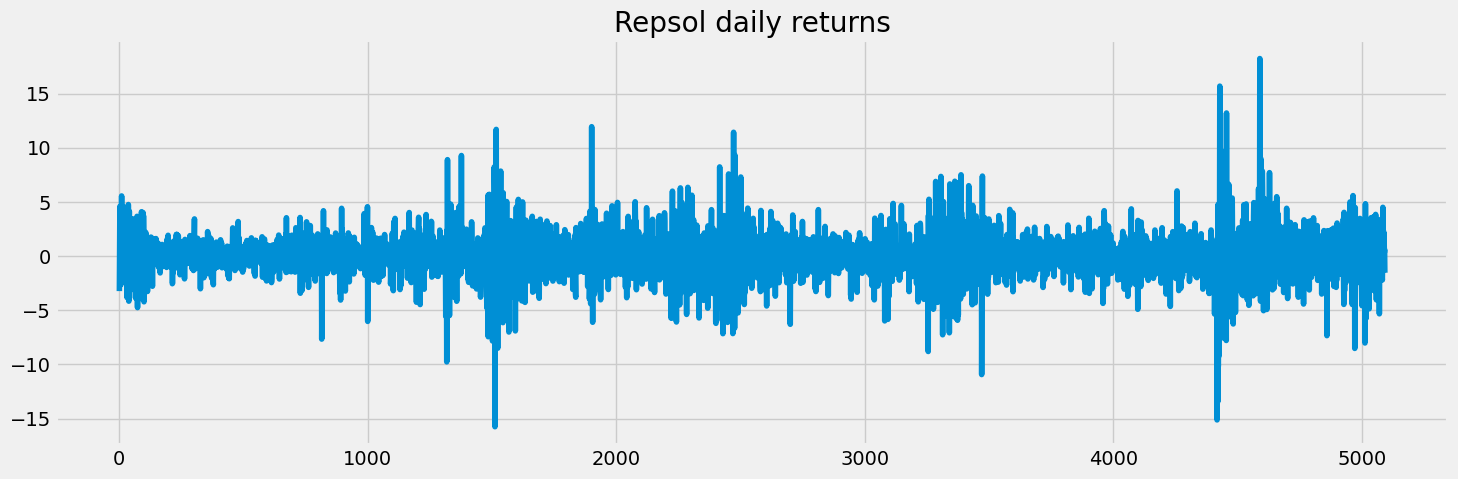

In [7]:
#We can plot the daily retuns of repsol using a line graph using .plot from pandas
returns_repsol.plot(figsize =(16,5), title = 'Repsol daily returns');

In [8]:
#We create a distribution plot using plotly.figure_factory, we reshape the data to have them in a vector
return_dist_plot  = ff.create_distplot([returns_repsol.values.reshape(-1)], group_labels = [' '])
#We specify the plot layout
return_dist_plot.update_layout(showlegend=False, title_text='Distribution of daily Repsol Returns', width=1000, height=500)
#Printing the plot
return_dist_plot.show()


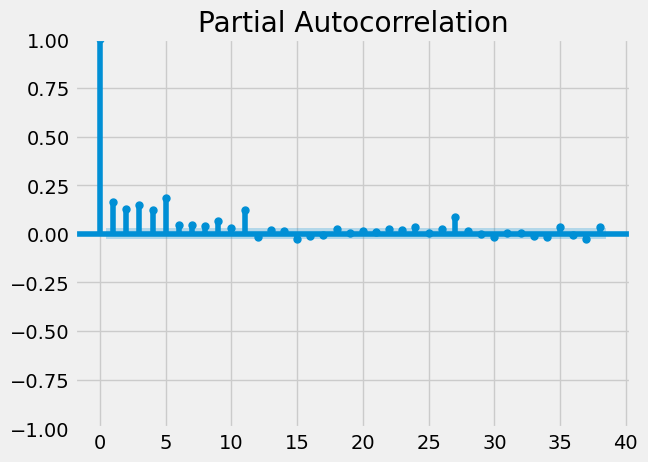

In [9]:
#This code uses the pacf() function from the tsa.stattools module of the statsmodels library (sm) to compute the autocorrelation function.
plot_pacf(returns_repsol**2,method="yw")
#Print the visualization
plt.show()

This graph shows the autocorrelation of squared returns, this positive result will let us to predict volatility using a GARCH model, or either adding the previous volatility as a feature to our XGBoost model.

GARCH

In [10]:
#Define a GARCH model (4,4) that uses a ged distribution
model = arch_model(returns_repsol,dist="ged", vol = 'GARCH', p=4, q=4)
#Fit the model
model_fit = model.fit(disp='off')
#Summary of the model
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Constant Mean - GARCH Model Results                            
==========================================================================================
Dep. Variable:                              close   R-squared:                       0.000
Mean Model:                         Constant Mean   Adj. R-squared:                  0.000
Vol Model:                                  GARCH   Log-Likelihood:               -9576.84
Distribution:      Generalized Error Distribution   AIC:                           19175.7
Method:                        Maximum Likelihood   BIC:                           19247.4
                                                    No. Observations:                 5018
Date:                            Tue, Aug 19 2025   Df Residuals:                     5017
Time:                                    16:43:18   Df Model:                            1
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0519  1.933e-02      2.686  7.234e-03 [1.403e-02,8.980e-02]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.1136  3.057e-02      3.716  2.026e-04   [5.367e-02,  0.173]
alpha[1]       0.0832  1.562e-02      5.325  1.009e-07   [5.256e-02,  0.114]
alpha[2]       0.0544  1.985e-02      2.743  6.090e-03 [1.554e-02,9.335e-02]
alpha[3]       0.0551  1.981e-02      2.783  5.386e-03 [1.631e-02,9.396e-02]
alpha[4]       0.0579  1.711e-02      3.385  7.131e-04 [2.437e-02,9.143e-02]
beta[1]        0.0000      0.130      0.000      1.000     [ -0.254,  0.254]
beta[2]    5.8199e-03      0.108  5.383e-02      0.957     [ -0.206,  0.218]
beta[3]        0.0000      0.113      0.000      1.000     [ -0.222,  0.222]
beta[4]        0.7151  8.267e-02      8.651  5.124e-18     [  0.553,  0.877]
                              Distribution                              
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
nu             1.3476  4.274e-02     31.528 3.548e-218 [  1.264,  1.431]
========================================================================

Covariance estimator: robust
"""

In [11]:
#Define the full serie as the previosly defined model
full_serie_garch = arch_model(returns_repsol,dist="ged", vol = 'GARCH', p=4, q=4)
#Fitting the model for the full serie
model_fit_full_serie = full_serie_garch.fit(disp='off')
#We will plot against the rolling volatility
rolling_vol = abs(returns_repsol.rolling(window=22, min_periods=22).std().dropna())
#Concatenating the true values, and trained values in our model
garch_and_rolling_std = pd.concat([pd.DataFrame(model_fit_full_serie.conditional_volatility),rolling_vol.dropna()], axis=1).dropna()
#Plotting it
garch_and_rolling_std_plot = px.line(garch_and_rolling_std, title = 'GARCH vs rolling volatility of daily returns TRAIN', width=1000, height=500)
#Printing the plot
garch_and_rolling_std_plot.show()


In [12]:
#Using a numeric range of 251 to fill a list of predicted values, for each day we are fitting a new model with the same parameters, but adding the last day.
test_size = 251
rolling_predictions = []

for i in range(test_size):
    train = returns_repsol[:-(test_size-i)]
    model = arch_model(train,dist="ged", vol = 'GARCH', p=4, q=4)
    model_fit = model.fit(disp='off')
    pred = model_fit.forecast(horizon=1, reindex = False)
    rolling_predictions.append(np.sqrt(pred.variance.values[-1,:][0]))

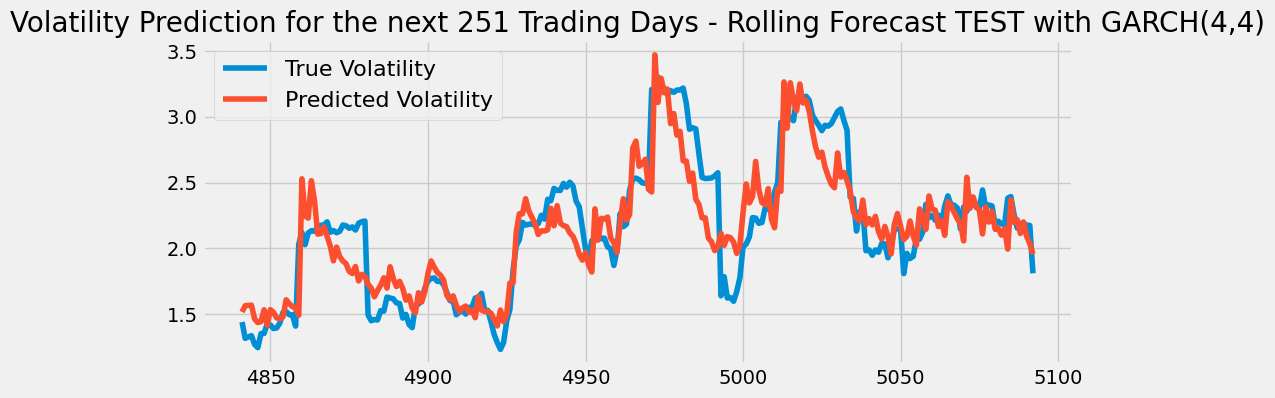

In [13]:
#Transforming it to a serie 
rolling_predictions = pd.Series(rolling_predictions, index= returns_repsol.dropna().index[-test_size:])
#Setting plot parameters
plt.figure(figsize=(10,4))
#True data 
true, = plt.plot((rolling_vol)[-test_size:])
#Predicted data
preds, = plt.plot(rolling_predictions)
#Plot of the data
plt.title('Volatility Prediction for the next 251 Trading Days - Rolling Forecast TEST with GARCH(4,4)', fontsize=20)
#Add legend
plt.legend(['True Volatility', 'Predicted Volatility'], fontsize=16)

XGBoost

In [15]:
#Read the raw data again, we will be transforming it in a different way
repsol_stock_raw_data_for_ml = pd.read_csv(r"C:\Users\Acer\Downloads\repsol stock data\RepsolStockData20Years.csv")
#We only need the date and close columns
returns_repsol_for_ml = repsol_stock_raw_data_for_ml[["date","close"]]
#We change the close column for the percentual change calculation
returns_repsol_for_ml["close"] = 100 * repsol_stock_raw_data.close.pct_change().dropna()
#Drop 0 returns
returns_repsol_for_ml  = returns_repsol_for_ml.drop(returns_repsol_for_ml[returns_repsol_for_ml["close"] == 0].index)
#Drop N/A
returns_repsol_for_ml = returns_repsol_for_ml.dropna()
#As we will be comparing it to the rolling volatility of 22 days, we will transform our target to that
returns_repsol_for_ml["close"] = abs(returns_repsol_for_ml["close"].rolling(window=22, min_periods=22).std().dropna())
#Convert the date column to datetime format
returns_repsol_for_ml["date"] = pd.to_datetime(returns_repsol_for_ml["date"])
#Rename the dataframe
serie_for_xgboost = returns_repsol_for_ml
#Set the test size
test_size = 251
#Split train and test
train_ml = serie_for_xgboost[:-(test_size)].dropna()
test_ml = serie_for_xgboost[-(test_size):].dropna()

In [16]:
#UDF for extracting features from date
def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    
    
    X = df[['dayofweek','quarter','month','year',
           'dayofyear','dayofmonth']]
    if label:
        y = df[label]
        return X, y
    return X

In [17]:
#Creating the features for the train and test sets
X_train, y_train = create_features(train_ml, label="close")
X_test, y_test = create_features(test_ml, label="close")

In [18]:
#Creating an aditional feature that uses the 4 previous days of rolling volatility, incorporating the autoregressive component to our ML model
X_train['prev1']=train_ml['close'].shift(1)
X_test['prev1']=test_ml['close'].shift(1)
X_train['prev2'] =train_ml['close'].shift(2)
X_test['prev2']=test_ml['close'].shift(2)
X_train['prev3'] =train_ml['close'].shift(3)
X_test['prev3']=test_ml['close'].shift(3)
X_train['prev4'] =train_ml['close'].shift(4)
X_test['prev4']=test_ml['close'].shift(4)

In [19]:
#Defining and fitting the model
reg = xgb.XGBRegressor(n_estimators=1000,early_stopping_rounds=50,)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
       verbose=False)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,50
,enable_categorical,False
,eval_metric,None


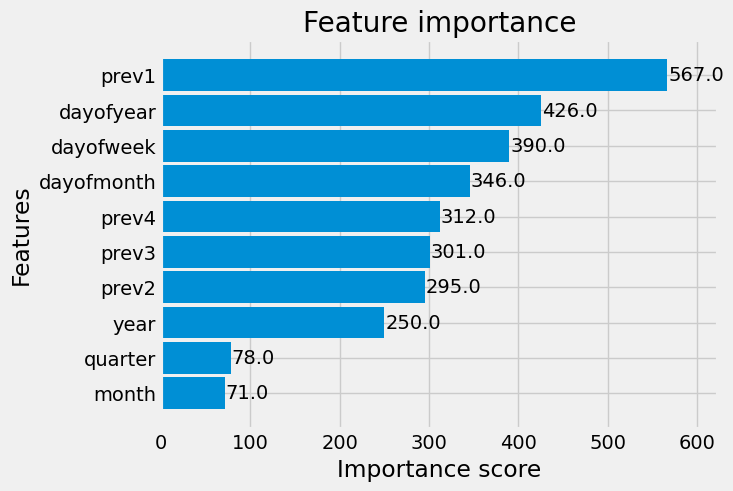

In [20]:
#Plot of feature importance
_ = plot_importance(reg, height=0.9)

In [21]:
#Predicting with our model for both the train and test data
train_ml["Predictions"] = reg.predict(X_train)
test_ml['Prediction'] = reg.predict(X_test)

In [22]:
#Creating the dataframe with both real and predicted vol
XGBoost_and_rolling = pd.concat([pd.DataFrame(list(train_ml["Predictions"]),list(train_ml["close"]))], axis=1).dropna().reset_index()
#Renaming columns
XGBoost_and_rolling.rename(columns={"index":"Real_Volatility",0:"Predicted Volatility"}, inplace=True)
XGBoost_and_rolling.head(3)

,Real_Volatility,Predicted Volatility
0,2.321532,2.314899
1,2.166931,2.262856
2,2.183926,2.170107


In [23]:
#Plotting the predictions of the training data
XGBoost_and_rolling = pd.concat([pd.DataFrame(list(train_ml["Predictions"]),list(train_ml["close"]))], axis=1).dropna().reset_index()
XGBoost_and_rolling.rename(columns={"index":"Real_Volatility",0:"Predicted Volatility"}, inplace=True)
XGBoost_and_rolling = px.line(XGBoost_and_rolling, title = 'XGBOOST vs rolling volatility of daily returns TRAIN', width=1000, height=500)
XGBoost_and_rolling.show()


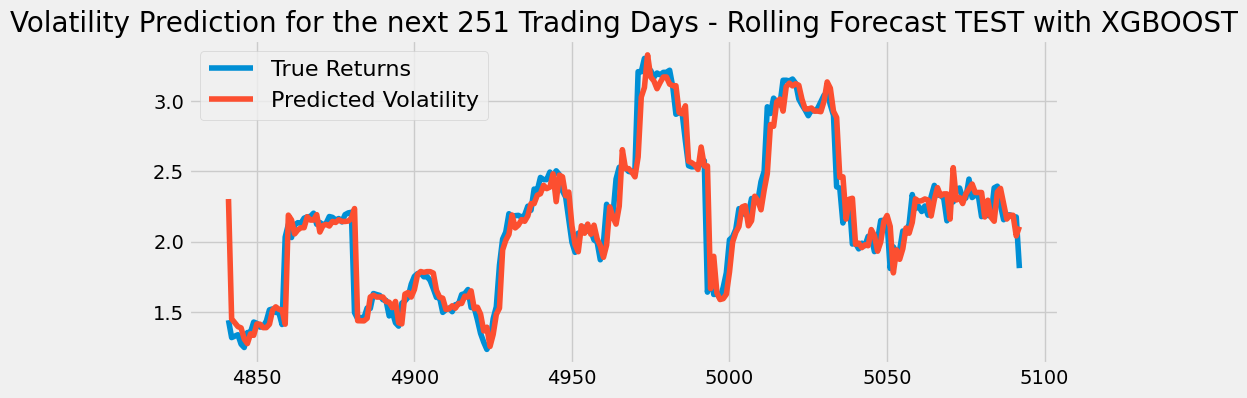

In [24]:
#Plotting the predictions for the test data
plt.figure(figsize=(10,4))
true, = plt.plot(test_ml["close"])
preds, = plt.plot(test_ml['Prediction'])
plt.title('Volatility Prediction for the next 251 Trading Days - Rolling Forecast TEST with XGBOOST', fontsize=20)
plt.legend(['True Returns', 'Predicted Volatility'], fontsize=16)

Root Mean Square Error, RMSE: Square root of the mean of the difference between the actual data points and the squared prediction value. It penalizes greater or extreme differences more.

Mean Absolute Percentage Error, MAPE: It allows to measure errors relative to the magnitude of the real value.

In [27]:
MSE_Serie = mean_squared_error(
    garch_and_rolling_std["close"],
    garch_and_rolling_std["cond_vol"]
)
RMSE_Serie = np.sqrt(MSE_Serie)

MAPE_Serie = mean_absolute_percentage_error(garch_and_rolling_std["close"], garch_and_rolling_std["cond_vol"])
print(f"The RMSE of our GARCH model in the full serie data is {round(RMSE_Serie,4)}")
print(f"The MAPE of our GARCH model in the full serie data is {round(MAPE_Serie*100,2)}%")

The RMSE of our GARCH model in the full serie data is 0.2397
The MAPE of our GARCH model in the full serie data is 12.07%


In [28]:
true_vol = rolling_vol[-test_size:]
pred_vol = rolling_predictions

# First calculate MSE, then take sqrt for RMSE
MSE = mean_squared_error(true_vol, pred_vol)
RMSE = np.sqrt(MSE)

# MAPE works fine, no change needed
MAPE = mean_absolute_percentage_error(true_vol, pred_vol)

print(f"The RMSE of our GARCH model in the predicted data is {round(RMSE,4)}")
print(f"The MAPE of our GARCH model in the predicted data is {round(MAPE*100,2)}%")


The RMSE of our GARCH model in the predicted data is 0.23
The MAPE of our GARCH model in the predicted data is 8.38%


In [29]:
# Calculate RMSE manually to avoid issues with sklearn version
MSE_Serie_XG = mean_squared_error(train_ml["close"], train_ml["Predictions"])
RMSE_Serie_XG = np.sqrt(MSE_Serie_XG)

# MAPE works fine as is
MAPE_Serie_XG = mean_absolute_percentage_error(train_ml["close"], train_ml["Predictions"])

print(f"The RMSE of our XGBOOST model in the full serie data is {round(RMSE_Serie_XG,4)}")
print(f"The MAPE of our XGBOOST model in the full serie data is {round(MAPE_Serie_XG*100,2)}%")


The RMSE of our XGBOOST model in the full serie data is 0.0972
The MAPE of our XGBOOST model in the full serie data is 3.47%


In [30]:
true_vol = test_ml['Prediction']
pred_vol = test_ml["close"]

# RMSE calculation (manual sqrt for compatibility)
MSE_XG = mean_squared_error(true_vol, pred_vol)
RMSE_XG = np.sqrt(MSE_XG)

# MAPE
MAPE_XG = mean_absolute_percentage_error(true_vol, pred_vol)

print(f"The RMSE of our XGBOOST model in the predicted data is {round(RMSE_XG,4)}")
print(f"The MAPE of our XGBOOST model in the predicted data is {round(MAPE_XG*100,2)}%")


The RMSE of our XGBOOST model in the predicted data is 0.1533
The MAPE of our XGBOOST model in the predicted data is 4.35%


In [31]:
print(tabulate([['MAPE',round(MAPE_Serie*100,2),round(MAPE_Serie_XG*100,2),round(MAPE*100,2),round(MAPE_XG*100,2)]],headers = ['GARCH TRAIN %', 'XGBOOST TRAIN %', 'GARCH PREDICTIONS %','XGBOOST PREDICTIONS %'],tablefmt = 'fancy_grid',stralign='center',numalign='center',floatfmt=".2f"))

╒══════╤═════════════════╤═══════════════════╤═══════════════════════╤═════════════════════════╕
│      │  GARCH TRAIN %  │  XGBOOST TRAIN %  │  GARCH PREDICTIONS %  │  XGBOOST PREDICTIONS %  │
╞══════╪═════════════════╪═══════════════════╪═══════════════════════╪═════════════════════════╡
│ MAPE │      12.07      │       3.47        │         8.38          │          4.35           │
╘══════╧═════════════════╧═══════════════════╧═══════════════════════╧═════════════════════════╛


Our project has shown that the GARCH model can effectively predict the monthly rolling volatility of Repsol's stock. However, other modern approaches like XGBoost can improve upon this, as seen in our results where the MAPE was reduced by half to 4.43%. This project showcases the utility of both Machine Learning and GARCH for forecasting stock volatility, and underscores the importance of taking into account the time-varying nature of volatility in financial analysis. While this findings are promising, further research is needed to test these theories across a wider range of stocks, markets, and models in order to reach more general conclusions.